In [0]:
import tensorflow as tf

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
import os


In [4]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                   fname = 'flower_photos', untar=True)

228818944/228813984 [==============================] - 1s 0us/step


In [0]:
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [7]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['tulips', 'sunflowers', 'daisy', 'roses', 'dandelion'],
      dtype='<U10')

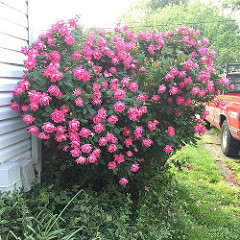

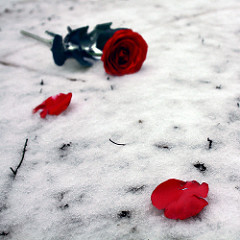

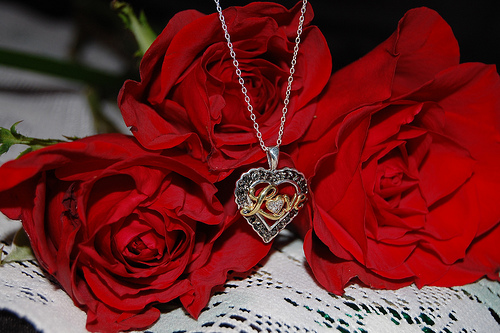

In [8]:
roses = list(data_dir.glob('roses/*'))
for image_path in roses[:3]:
  display.display(Image.open(str(image_path)))

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [11]:
train_data_gen = image_generator.flow_from_directory(
    directory=str(data_dir),
    batch_size = BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes = list(CLASS_NAMES)
)

Found 3670 images belonging to 5 classes.


In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10, 10))
  for n in range(25):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
    plt.axis('off')

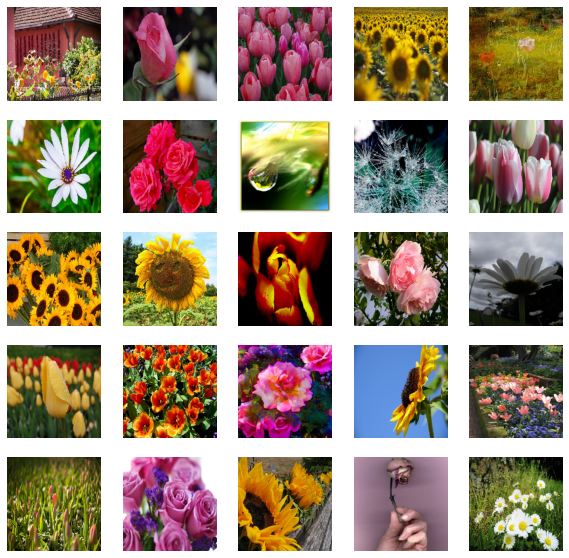

In [20]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [22]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/sunflowers/197011740_21825de2bf.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/14244410747_22691ece4a_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/16616096711_12375a0260_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/17702388233_f29dc14834_m.jpg'
b'/root/.keras/datasets/flower_photos/tulips/471298577_cc7558bcf1.jpg'


In [0]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [33]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False  True False]


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds
  

In [0]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

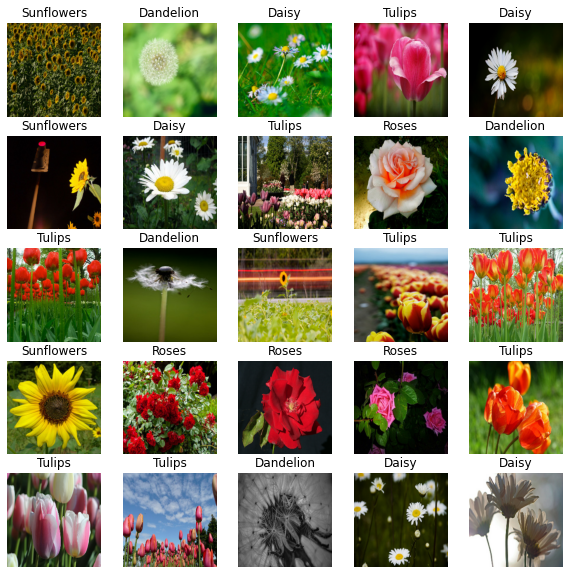

In [38]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
#Hieu suat
import time
default_timeit_steps = 1000
def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10==0:
      print('.', end='')
  print()
  end = time.time()
  duration = end - start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))
  

In [40]:
timeit(train_data_gen)

....................................................................................................
1000 batches: 113.04521250724792 s
283.07258 Images/s
